In [1]:
from os.path import join as jn
import shelve

import numpy as np
import networkx as nx
from tqdm.notebook import tqdm_notebook

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import EMB

ROOT = jn("..", "..", "")
DATA = jn(ROOT, "data", "")
FIGURES = jn(ROOT, "results", "figures", "")

In [2]:
N = 1_000
k = 128
MUS = np.linspace(0.1, 0.5, num=20)
GAMMAS = np.linspace(2.1, 3.9, num=20)

In [3]:
shelf = shelve.open(jn(DATA, "data_exp-mu-gamma-phasespace-LE.shelf"))

for mu in tqdm_notebook(MUS, colour="red", desc="mu", leave=True):
    for gamma in tqdm_notebook(GAMMAS, colour="blue", desc="gamma", leave=False):
        if shelf.get(f"{mu}-{gamma}", None) is not None:
            # print(f"Data exists in shelf, skipping this mu,gamma pair (mu-gamma={mu}-{gamma})!")
            continue

        rel_dists_ = []
        perfs_ = []
        for _ in range(5):
            # 1 Generate duplex
            G = EMB.netsci.models.benchmarks.generate_network_LFR(
                    N, gamma, 1.0, mu, 6, np.sqrt(N), 1, ROOT
            )[0]
            H = EMB.netsci.models.benchmarks.generate_network_LFR(
                    N, gamma, 1.0, mu, 6, np.sqrt(N), 1, ROOT
            )[0]

            D = dict(enumerate(EMB.netsci.models.preprocessing.make_layers_disjoint(G, H)))

            # 2 Observe remnants
            remnant_multiplex = EMB.remnants.observer.random_observations_multiplex(D, 0.3)
            remnant_multiplex = EMB.remnants.observer.build_remnant_multiplex(D, remnant_multiplex)

            # 3 Embed multiplex
            vectors = EMB.embeddings.embed_multiplex_LE(remnant_multiplex, k=k)

            # 4 Calculate features
            testing_edges = remnant_multiplex[-1].edges()
            training_edges = EMB.netsci.all_edges(*remnant_multiplex.values()) - set(testing_edges)
            y_train = {edge: EMB.netsci.find_edge(edge, *D.values())[0] for edge in training_edges}
            y_test = {edge: EMB.netsci.find_edge(edge, *D.values())[0] for edge in testing_edges}
            remnant_multiplex = EMB.utils.cutkey(remnant_multiplex, -1)
            components = {
                label: sorted(nx.connected_components(graph))
                for label, graph in remnant_multiplex.items()
            }
            vectors = EMB.utils.cutkey(vectors, -1)
            for label, vectorset in vectors.items():
                node2id = dict()
                vectors[label] = EMB.embeddings.normalize_vectors(vectorset, components[label], node2id=node2id)
            training_distances = EMB.classifiers.get_distances_feature(vectors.values(), training_edges, training=True)
            testing_distances = EMB.classifiers.get_distances_feature(vectors.values(), testing_edges, training=False)
            training_degrees = EMB.classifiers.get_degrees_feature(remnant_multiplex.values(), training_edges, training=True)
            testing_degrees = EMB.classifiers.get_degrees_feature(remnant_multiplex.values(), testing_edges, training=False)
            X_train = np.array([training_distances, training_degrees]).transpose()
            X_test = np.array([testing_distances, testing_degrees]).transpose()

            # 5 Train model
            model = EMB.classifiers.train_model(X_train, list(y_train.values()))

            # 6 Retrieve coefficient relation
            dists, degs = model.coef_[0]
            rel_dists = abs(dists) / (abs(dists) + abs(degs))
            _, auroc, _ = EMB.classifiers.evaluate_model(model, X_test, list(y_test.values()))
            rel_dists_.append(rel_dists)
            perfs_.append(auroc)

        # 7 Add evaluation to records
        shelf[f"{mu}-{gamma}"] = (np.mean(rel_dists_), np.mean(perfs_))

shelf.close()

mu:   0%|          | 0/20 [00:00<?, ?it/s]

gamma:   0%|          | 0/20 [00:00<?, ?it/s]

gamma:   0%|          | 0/20 [00:00<?, ?it/s]

gamma:   0%|          | 0/20 [00:00<?, ?it/s]

gamma:   0%|          | 0/20 [00:00<?, ?it/s]

gamma:   0%|          | 0/20 [00:00<?, ?it/s]

gamma:   0%|          | 0/20 [00:00<?, ?it/s]

gamma:   0%|          | 0/20 [00:00<?, ?it/s]

gamma:   0%|          | 0/20 [00:00<?, ?it/s]

gamma:   0%|          | 0/20 [00:00<?, ?it/s]

gamma:   0%|          | 0/20 [00:00<?, ?it/s]

gamma:   0%|          | 0/20 [00:00<?, ?it/s]

gamma:   0%|          | 0/20 [00:00<?, ?it/s]

gamma:   0%|          | 0/20 [00:00<?, ?it/s]

gamma:   0%|          | 0/20 [00:00<?, ?it/s]

gamma:   0%|          | 0/20 [00:00<?, ?it/s]

gamma:   0%|          | 0/20 [00:00<?, ?it/s]

gamma:   0%|          | 0/20 [00:00<?, ?it/s]

gamma:   0%|          | 0/20 [00:00<?, ?it/s]

gamma:   0%|          | 0/20 [00:00<?, ?it/s]

gamma:   0%|          | 0/20 [00:00<?, ?it/s]

In [4]:
with shelve.open(jn(DATA, "data_exp-mu-gamma-phasespace-LE.shelf")) as shelf:
    records = {key: value for key, value in shelf.items()}

In [5]:
rel_dists = []
perfs = []
for mu in MUS:
    for gamma in GAMMAS:
        rel_dists.append(records[f"{mu}-{gamma}"][0])
        perfs.append(records[f"{mu}-{gamma}"][1])

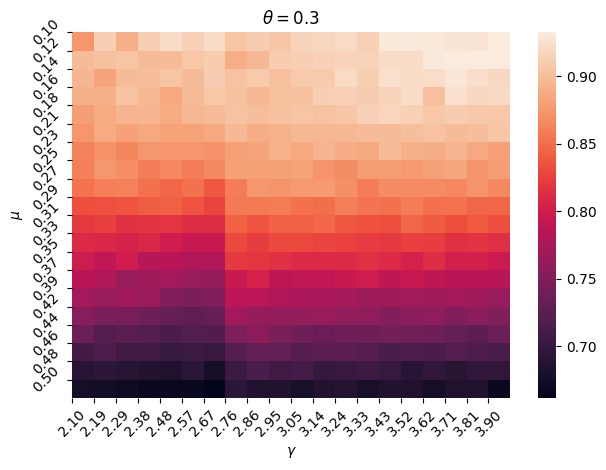

In [6]:
plt.figure()

sns.heatmap(np.array(perfs).reshape((len(MUS),len(GAMMAS))))

plt.xticks(range(len(GAMMAS)), labels=[f"{x:.2f}" for x in GAMMAS], rotation=45)
plt.yticks(range(len(MUS)), labels=[f"{x:.2f}" for x in MUS], rotation=45)
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$\mu$")

plt.title(r"$\theta=0.3$")
plt.tight_layout()
plt.savefig(jn(FIGURES, "figure_heatmap-perf-mu-gamma_data-LFR-theta-0.3_LE.png"), transparent=False, facecolor="white")